# House sales predictions

## Introduction

## Table of content
1. [Cleaning the data](#first-bullet)
2. [Data Exploration](#second-bullet)

    2.1 [Lets plot some features](#first-bullet)

## Data

## Imports

In [168]:
import numpy as np
import pandas as pd
import seaborn as sns
import pickle
import matplotlib.pyplot as plt
import statsmodels.formula.api as sm
import lightgbm as lgb
import xgboost as xgb
from sklearn.cross_validation import train_test_split
from sklearn.linear_model import LinearRegression , Ridge , Lasso
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn import ensemble
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_log_error
from sklearn import cross_validation
from sklearn.naive_bayes import GaussianNB
from sklearn.datasets import load_digits
from sklearn.learning_curve import learning_curve
from sklearn.cross_validation import ShuffleSplit
from sklearn.grid_search import GridSearchCV
from scipy import stats
from scipy.stats import norm, skew
from scipy.special import boxcox1p

pd.set_option('display.max_columns', None)
base = "./challenge_data/"

## Reading the data

In [169]:
# loading the data
houseDataDF = pd.read_csv(base + "train2.csv")
idColl = houseDataDF.Id
houseDataDF = houseDataDF.drop(["Id"],axis=1)
houseDataDF.index = idColl
print(houseDataDF.shape)

testDF = pd.read_csv(base + "test.csv")
idColl = testDF.Id
testDF = testDF.drop(["Id"],axis=1)
testDF.index = idColl
print(testDF.shape)

(1460, 80)
(260, 79)


# Data Exploration

Text(0.5,1,'Percent missing data by feature (training data)')

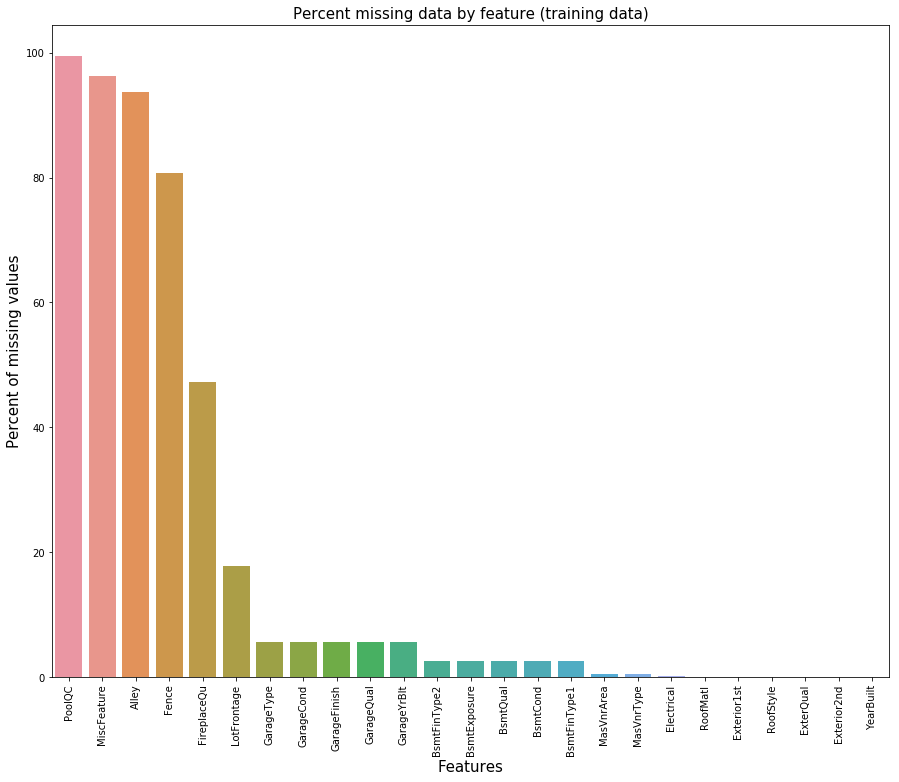

In [170]:
nulls = pd.DataFrame(houseDataDF.isnull().sum().sort_values(ascending=False)[:25])
nulls.columns = ['Null Count']
nulls.index.name = 'Feature'

f, ax = plt.subplots(figsize=(15, 12))
plt.xticks(rotation='90')
sns.barplot(x=list(nulls.index), y=nulls.values.ravel() * 100 /len(houseDataDF.values))
plt.xlabel('Features', fontsize=15)
plt.ylabel('Percent of missing values', fontsize=15)
plt.title('Percent missing data by feature (training data)', fontsize=15)

Text(0.5,1,'Percent missing data by feature (test data)')

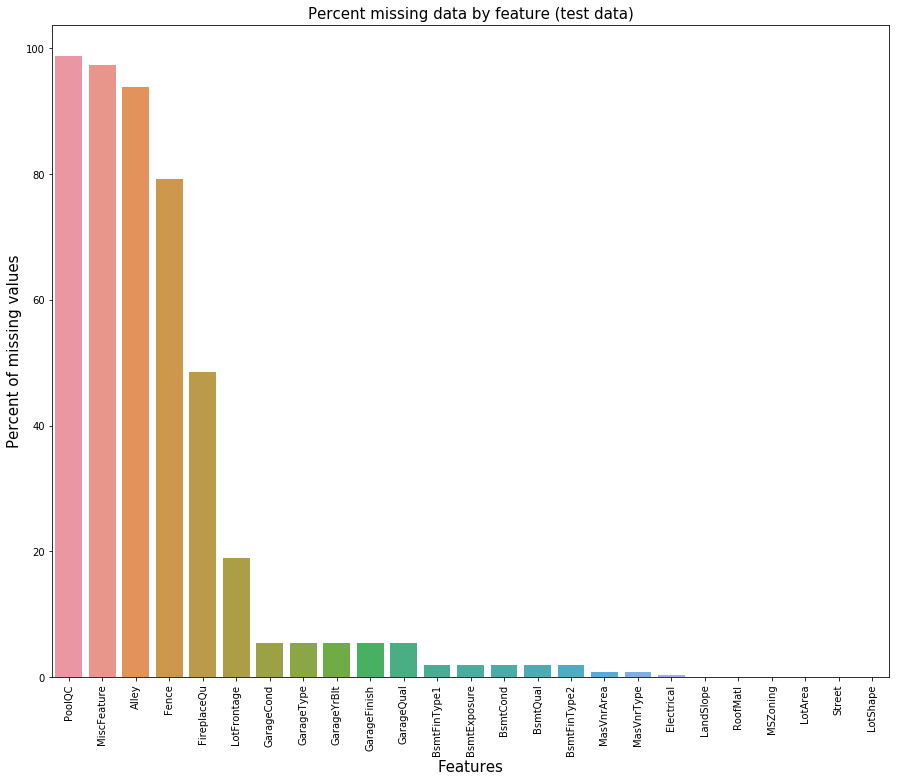

In [171]:
nulls = pd.DataFrame(testDF.isnull().sum().sort_values(ascending=False)[:25])
nulls.columns = ['Null Count']
nulls.index.name = 'Feature'

f, ax = plt.subplots(figsize=(15, 12))
plt.xticks(rotation='90')
sns.barplot(x=list(nulls.index), y=nulls.values.ravel() * 100 /len(testDF.values))
plt.xlabel('Features', fontsize=15)
plt.ylabel('Percent of missing values', fontsize=15)
plt.title('Percent missing data by feature (test data)', fontsize=15)

In [172]:
categoricals = houseDataDF.select_dtypes(exclude=[np.number])
categoricals.describe()

,MSZoning,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinType2,Heating,HeatingQC,CentralAir,Electrical,KitchenQual,Functional,FireplaceQu,GarageType,GarageFinish,GarageQual,GarageCond,PavedDrive,PoolQC,Fence,MiscFeature,SaleType,SaleCondition
count,1460,1460,91,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,1452,1460,1460,1460,1423,1423,1422,1423,1422,1460,1460,1460,1459,1460,1460,770,1379,1379,1379,1379,1460,7,281,54,1460,1460
unique,5,2,2,4,4,2,5,3,25,9,8,5,8,6,8,15,16,4,4,5,6,4,4,4,6,6,6,5,2,5,4,7,5,6,3,5,5,3,3,4,4,9,6
top,RL,Pave,Grvl,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Norm,Norm,1Fam,1Story,Gable,CompShg,VinylSd,VinylSd,None,TA,TA,PConc,TA,TA,No,Unf,Unf,GasA,Ex,Y,SBrkr,TA,Typ,Gd,Attchd,Unf,TA,TA,Y,Gd,MnPrv,Shed,WD,Normal
freq,1151,1454,50,925,1311,1459,1052,1382,225,1260,1445,1220,726,1141,1434,515,504,864,906,1282,647,649,1311,953,430,1256,1428,741,1365,1334,735,1360,380,870,605,1311,1326,1340,3,157,49,1267,1198


In [173]:
categoricals = testDF.select_dtypes(exclude=[np.number])
categoricals.describe()

,MSZoning,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinType2,Heating,HeatingQC,CentralAir,Electrical,KitchenQual,Functional,FireplaceQu,GarageType,GarageFinish,GarageQual,GarageCond,PavedDrive,PoolQC,Fence,MiscFeature,SaleType,SaleCondition
count,260,260,16,260,260,260,260,260,260,260,260,260,260,260,260,260,260,258,260,260,260,255,255,255,255,255,260,260,260,259,260,260,134,246,246,246,246,260,3,54,7,260,260
unique,5,1,2,4,4,1,5,3,24,8,2,5,8,6,5,11,12,4,4,3,6,4,3,4,6,6,6,4,2,3,4,5,5,5,3,3,4,3,2,4,3,5,5
top,RL,Pave,Grvl,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Norm,Norm,1Fam,1Story,Gable,CompShg,VinylSd,VinylSd,None,TA,TA,PConc,TA,TA,No,Unf,Unf,GasA,Ex,Y,SBrkr,TA,Typ,Gd,Attchd,Unf,TA,TA,Y,Gd,MnPrv,Shed,WD,Normal
freq,205,260,9,171,232,260,190,247,46,225,259,219,125,196,256,98,94,153,159,232,113,123,235,169,86,222,251,138,243,239,133,243,71,152,105,230,233,233,2,27,5,231,219


## Finding feature relations

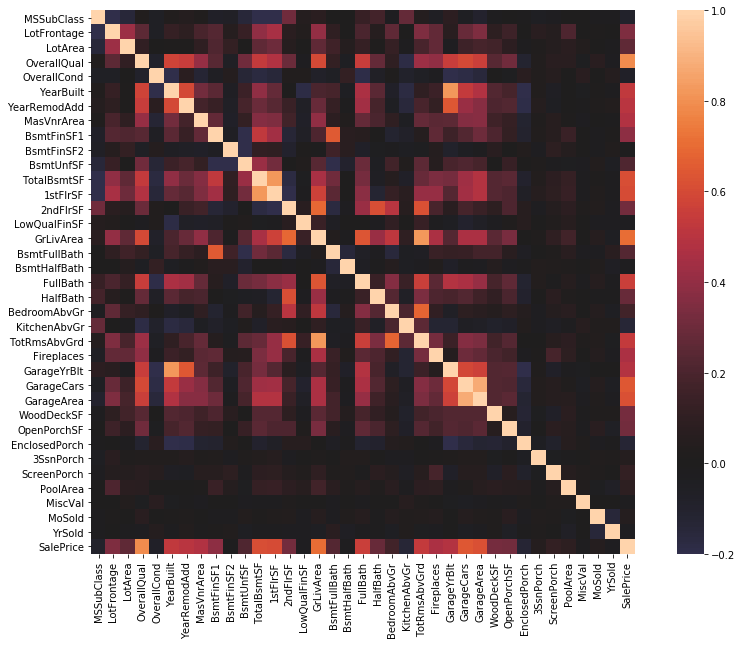

In [174]:
plt.figure(figsize=(15,10))
corr = houseDataDF.corr()


sns.heatmap(corr, 
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values,
            vmin=-0.2, square=True, center=0
           )

In [175]:

corrAsList = list(zip(corr.tail(1).values[0],list(corr)))

sortedCorr = sorted(corrAsList,key=lambda x : x[0],reverse=True)

print(pd.DataFrame(data=np.array(sortedCorr),columns=["Correlation","Feature"]))

              Correlation        Feature
0                     1.0      SalePrice
1      0.7909816005838047    OverallQual
2      0.7086244776126511      GrLivArea
3       0.640409197258349     GarageCars
4      0.6234314389183598     GarageArea
5      0.6135805515591944    TotalBsmtSF
6      0.6058521846919166       1stFlrSF
7      0.5606637627484452       FullBath
8      0.5337231555820238   TotRmsAbvGrd
9      0.5228973328794967      YearBuilt
10     0.5071009671113867   YearRemodAdd
11    0.48636167748786213    GarageYrBlt
12     0.4774930470957107     MasVnrArea
13     0.4669288367515242     Fireplaces
14    0.38641980624215627     BsmtFinSF1
15    0.35179909657067854    LotFrontage
16    0.32441344456813076     WoodDeckSF
17    0.31933380283206614       2ndFlrSF
18    0.31585622711605577    OpenPorchSF
19     0.2841076755947784       HalfBath
20     0.2638433538714063        LotArea
21    0.22712223313149718   BsmtFullBath
22      0.214479105546969      BsmtUnfSF
23     0.1682131

## Lets plot some features

https://www.kaggle.com/pmarcelino/comprehensive-data-exploration-with-python

/home/marius/.local/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64

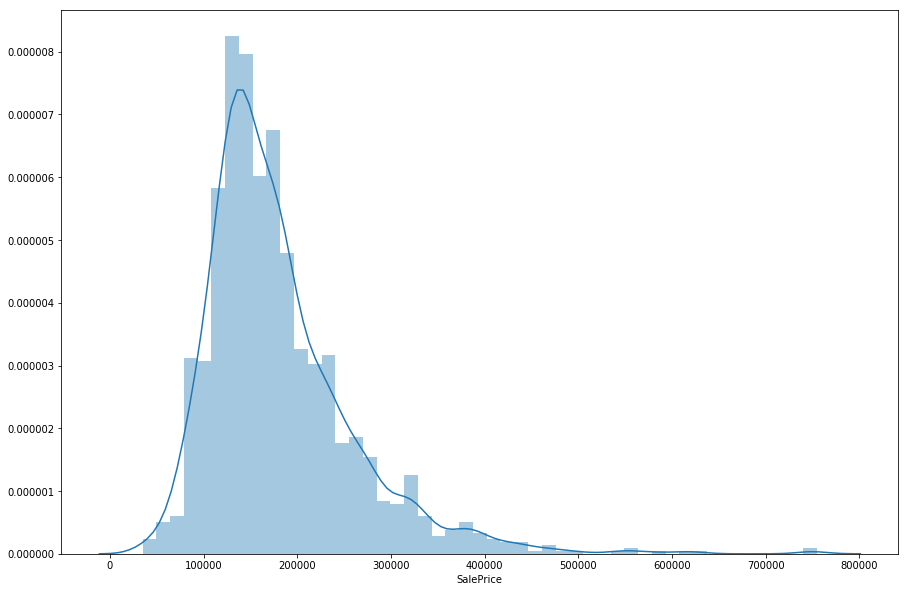

In [176]:
plt.figure(figsize=(15,10))
sns.distplot(houseDataDF.SalePrice)
houseDataDF.SalePrice.describe()

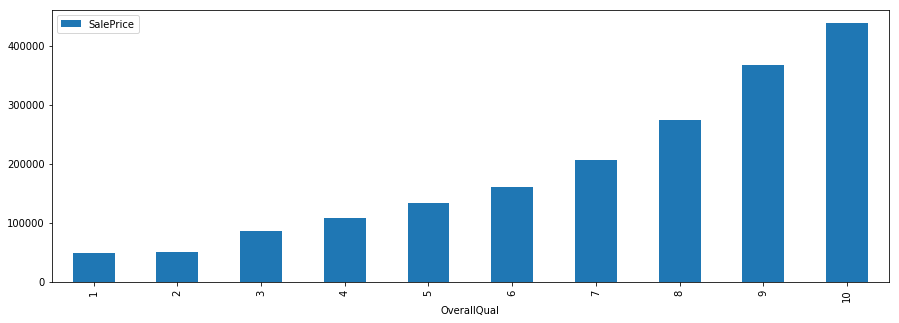

In [177]:
priceQualityDF = houseDataDF[["SalePrice","OverallQual"]]

avgPriceQualityDF = priceQualityDF.groupby(["OverallQual"]).mean()

avgPriceQualityDF.plot.bar(figsize=(15,5))

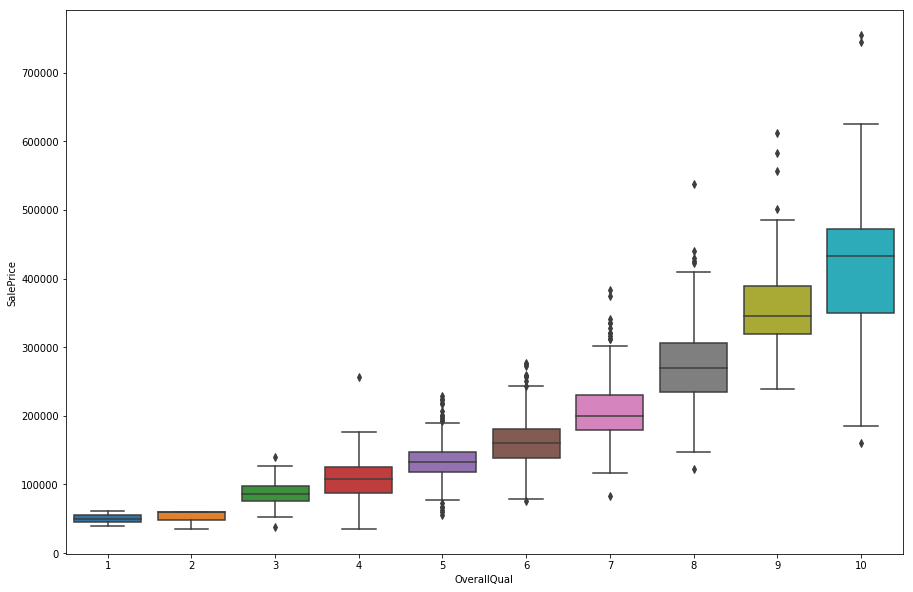

In [178]:
plt.figure(figsize=(15,10))
sns.boxplot(x='OverallQual',
               y='SalePrice', 
               data=houseDataDF)


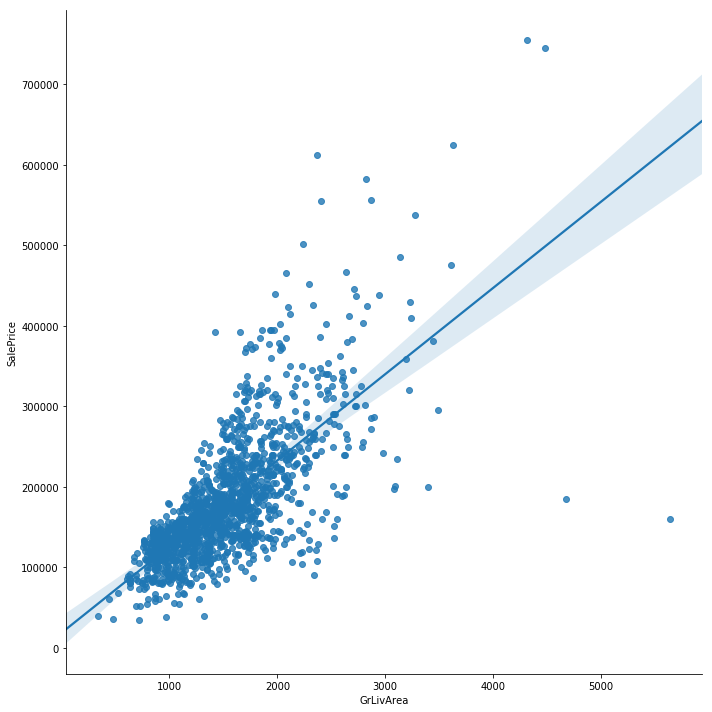

In [179]:
sns.lmplot(x="GrLivArea",y="SalePrice",data=houseDataDF,fit_reg=True,size=10) 

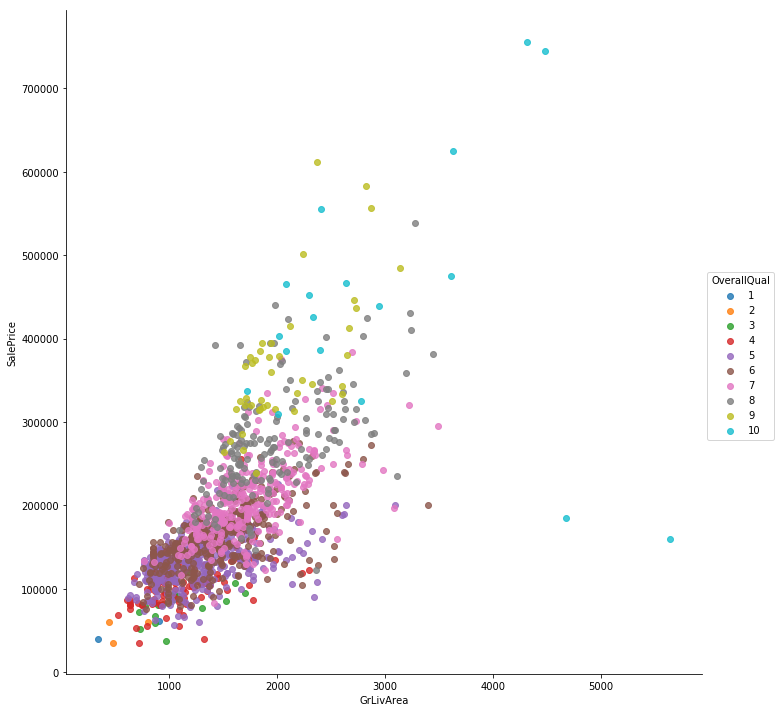

In [180]:
sns.lmplot(x="GrLivArea",y="SalePrice",data=houseDataDF,fit_reg=False,size=10,hue="OverallQual") 

In [181]:
res = houseDataDF.query('SalePrice <= 200000 & OverallQual == 10 ')
print(res.index)
values = np.array(res.values[0]).reshape(len(res.values[0]),1)
df = pd.DataFrame(data=values)
df.index = list(res)
print(df)

Int64Index([524, 1299], dtype='int64', name='Id')
                     0
MSSubClass          60
MSZoning            RL
LotFrontage        130
LotArea          40094
Street            Pave
Alley              NaN
LotShape           IR1
LandContour        Bnk
Utilities       AllPub
LotConfig       Inside
LandSlope          Gtl
Neighborhood   Edwards
Condition1        PosN
Condition2        PosN
BldgType          1Fam
HouseStyle      2Story
OverallQual         10
OverallCond          5
YearBuilt         2007
YearRemodAdd      2008
RoofStyle          Hip
RoofMatl       CompShg
Exterior1st    CemntBd
Exterior2nd    CmentBd
MasVnrType       Stone
MasVnrArea         762
ExterQual           Ex
ExterCond           TA
Foundation       PConc
BsmtQual            Ex
...                ...
BedroomAbvGr         3
KitchenAbvGr         1
KitchenQual         Ex
TotRmsAbvGrd        11
Functional         Typ
Fireplaces           1
FireplaceQu         Gd
GarageType     BuiltIn
GarageYrBlt       2007
GarageF

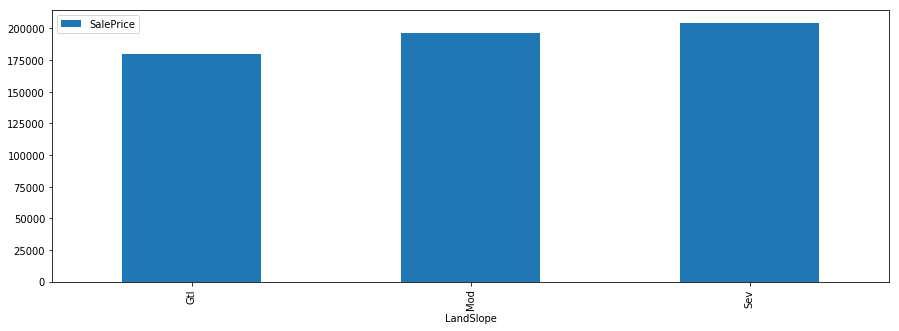

In [182]:
priceLandSlopeDF = houseDataDF[["SalePrice","LandSlope"]]

avgPriceLandSlopeDF = priceLandSlopeDF.groupby(["LandSlope"]).mean()

avgPriceLandSlopeDF.plot.bar(figsize=(15,5))

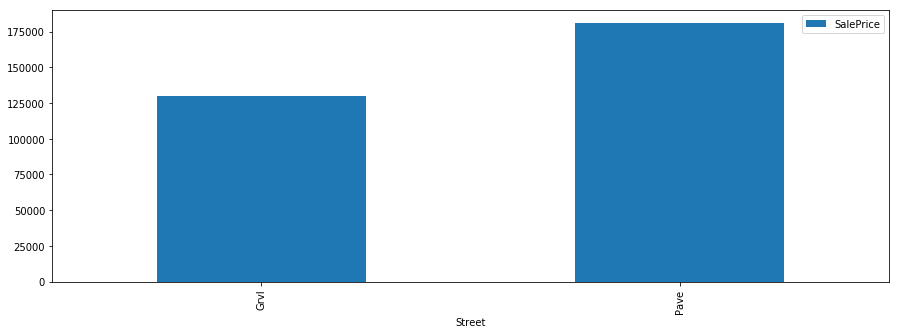

In [183]:
priceStreetDF = houseDataDF[["SalePrice","Street"]]

avgPriceStreetDF = priceStreetDF.groupby(["Street"]).mean()

avgPriceStreetDF.plot.bar(figsize=(15,5))

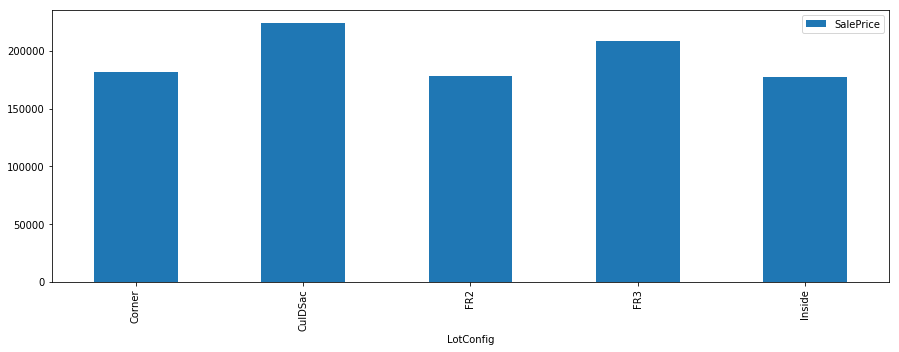

In [184]:
priceLotConfigDF = houseDataDF[["SalePrice","LotConfig"]]

avgPriceLotConfigDF = priceLotConfigDF.groupby(["LotConfig"]).mean()

avgPriceLotConfigDF.plot.bar(figsize=(15,5))

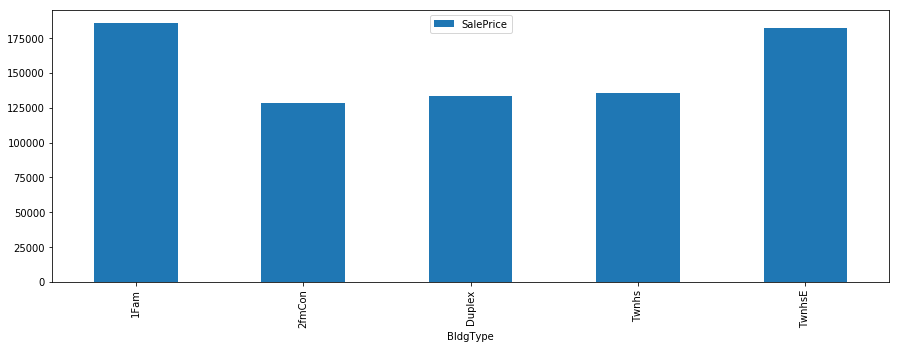

In [185]:
priceBldgTypeDF = houseDataDF[["SalePrice","BldgType"]]

avgPriceBldgTypeDF = priceBldgTypeDF.groupby(["BldgType"]).mean()

avgPriceBldgTypeDF.plot.bar(figsize=(15,5))

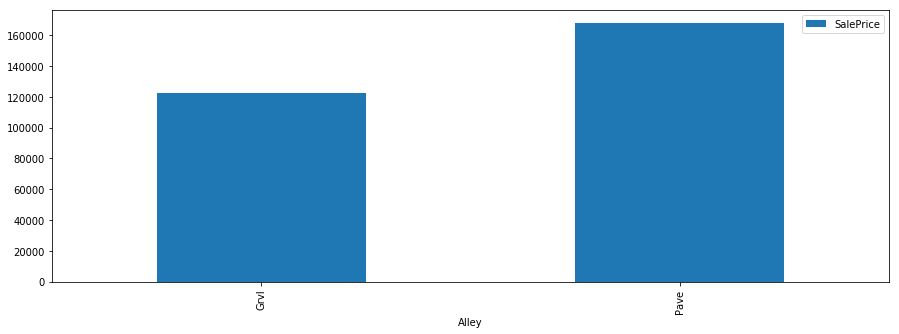

In [186]:
priceAlleyDF = houseDataDF[["SalePrice","Alley"]]

avgPriceAlleyDF = priceAlleyDF.groupby(["Alley"]).mean()

avgPriceAlleyDF.plot.bar(figsize=(15,5))

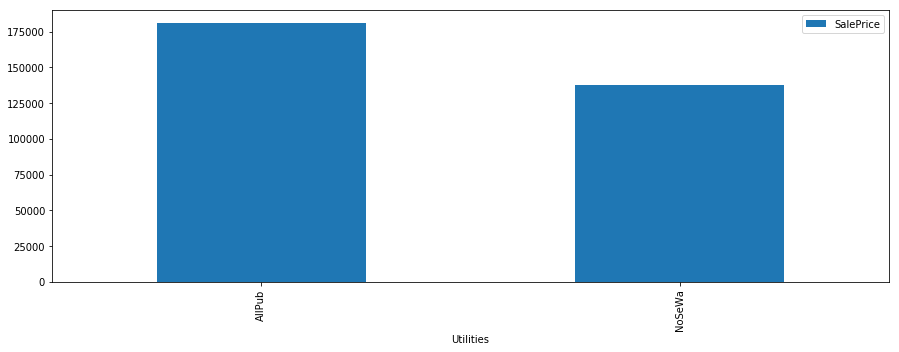

In [187]:
priceUtilitiesDF = houseDataDF[["SalePrice","Utilities"]]

avgPriceUtilitiesDF = priceUtilitiesDF.groupby(["Utilities"]).mean()

avgPriceUtilitiesDF.plot.bar(figsize=(15,5))

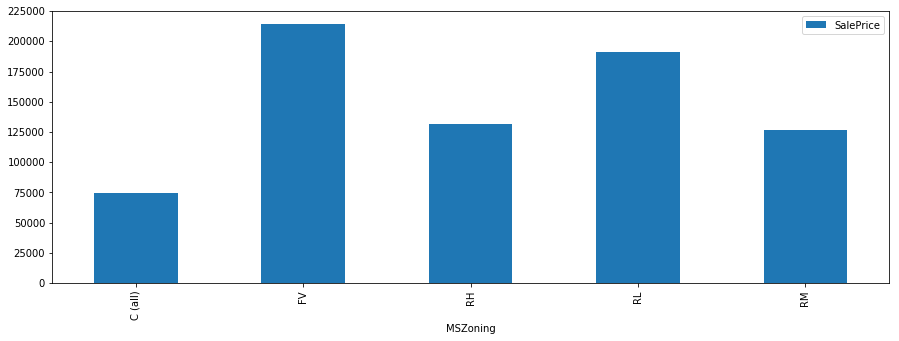

In [188]:
priceResidentialDF = houseDataDF[["SalePrice","MSZoning"]]

avgPriceResidentialDF = priceResidentialDF.groupby(["MSZoning"]).mean()

avgPriceResidentialDF.plot.bar(figsize=(15,5))

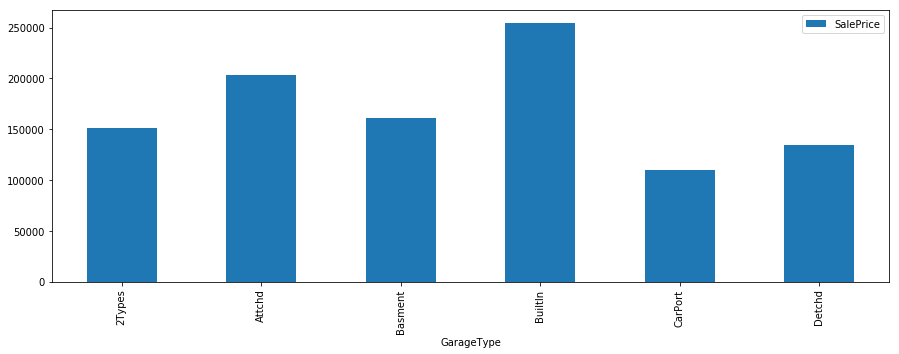

In [189]:
priceGarageTypeDF = houseDataDF[["SalePrice","GarageType"]]

avgPriceGarageTypeDF = priceGarageTypeDF.groupby(["GarageType"]).mean()

avgPriceGarageTypeDF.plot.bar(figsize=(15,5))

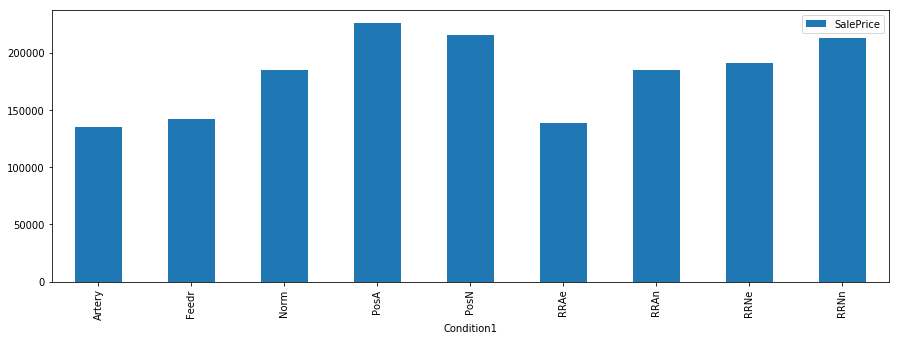

In [190]:
priceCondition1DF = houseDataDF[["SalePrice","Condition1"]]

avgPriceCondition1DF = priceCondition1DF.groupby(["Condition1"]).mean()

avgPriceCondition1DF.plot.bar(figsize=(15,5))

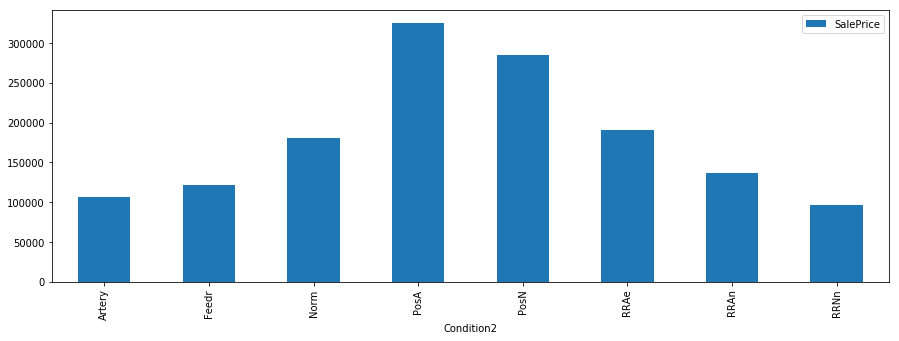

In [191]:
priceCondition2DF = houseDataDF[["SalePrice","Condition2"]]

avgPriceCondition2DF = priceCondition2DF.groupby(["Condition2"]).mean()

avgPriceCondition2DF.plot.bar(figsize=(15,5))

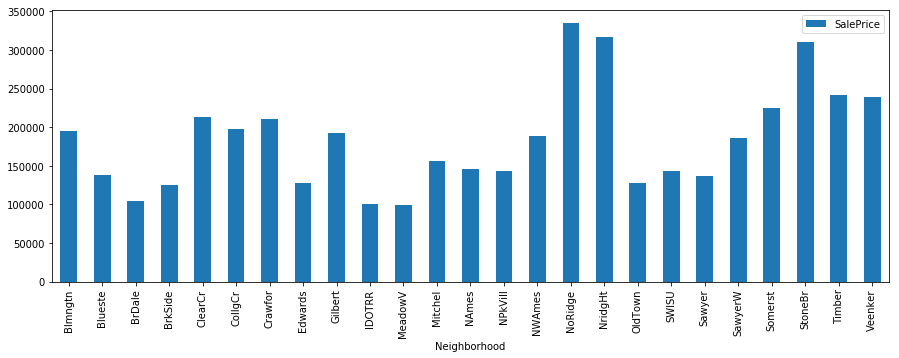

In [192]:
priceNeighborhoodDF = houseDataDF[["SalePrice","Neighborhood"]]

avgPriceNeighborhoodDF = priceNeighborhoodDF.groupby(["Neighborhood"]).mean()

avgPriceNeighborhoodDF.plot.bar(figsize=(15,5))

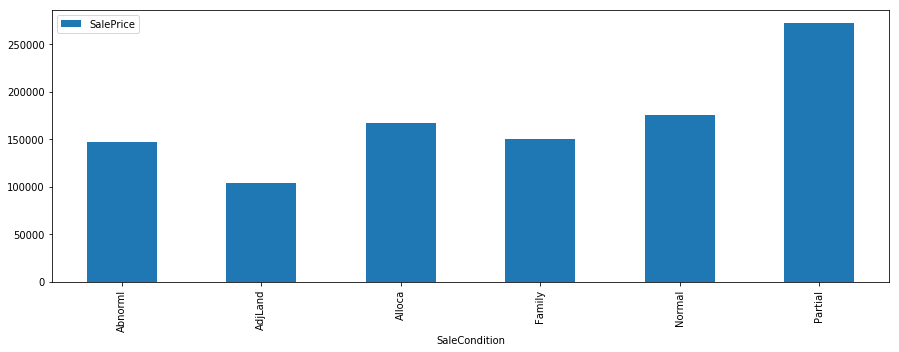

In [193]:
priceConditionDF = houseDataDF[["SalePrice","SaleCondition"]]

avgPriceConditionDF = priceConditionDF.groupby(["SaleCondition"]).mean()

avgPriceConditionDF.plot.bar(figsize=(15,5))

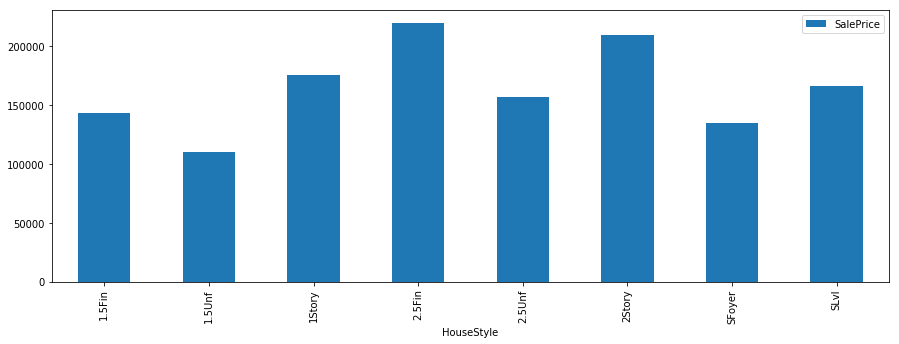

In [194]:
priceHouseStyleDF = houseDataDF[["SalePrice","HouseStyle"]]

avgPriceHouseStyleDF = priceHouseStyleDF.groupby(["HouseStyle"]).mean()

avgPriceHouseStyleDF.plot.bar(figsize=(15,5))

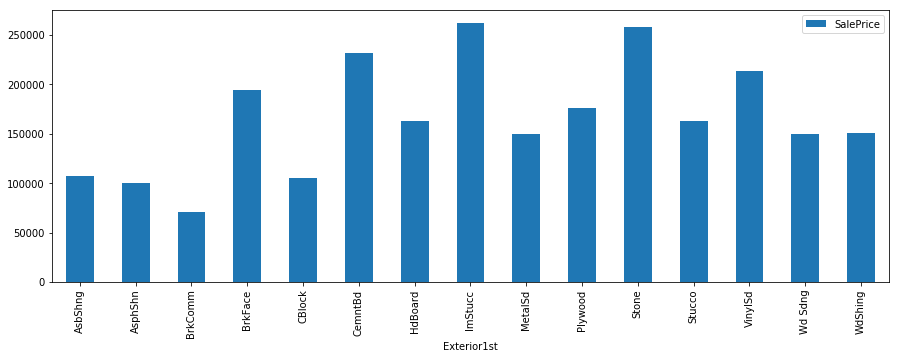

In [195]:
priceExterior1stDF = houseDataDF[["SalePrice","Exterior1st"]]

avgPriceExterior1stDF = priceExterior1stDF.groupby(["Exterior1st"]).mean()

avgPriceExterior1stDF.plot.bar(figsize=(15,5))

# Cleaning the data

## Removing outliers

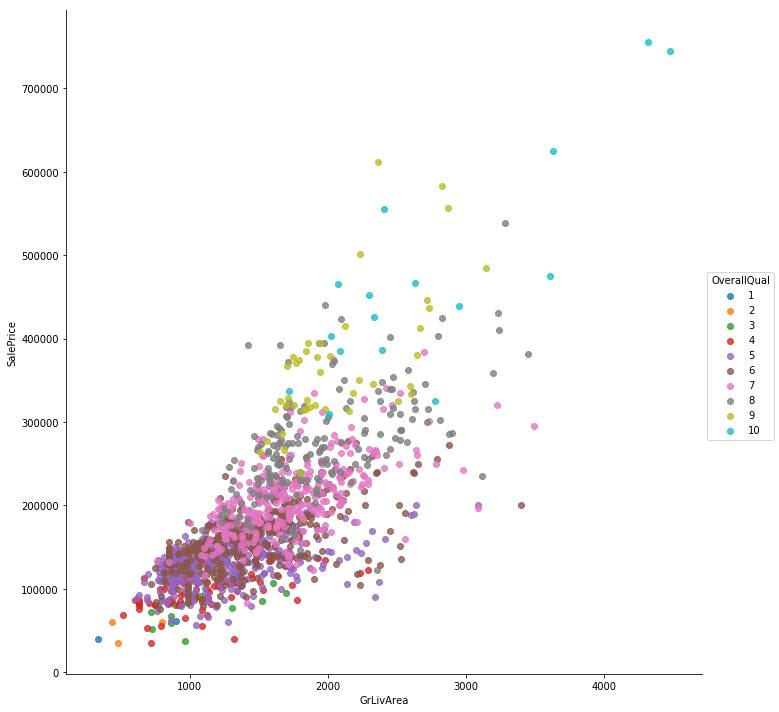

In [196]:
houseDataCleanedDF = houseDataDF.drop([524,1299])

sns.lmplot(x="GrLivArea",y="SalePrice",data=houseDataCleanedDF,fit_reg=False,size=10,hue="OverallQual")

## Feature engineering

In [197]:
def makeFeatures(houseDataDF):

    if(len(houseDataDF.Street.unique()) > 1):
        houseDataDF['EncodedStreet'] = pd.get_dummies(houseDataDF.Street, drop_first=True)
    else:
        houseDataDF['EncodedStreet'] = pd.get_dummies(houseDataDF.Street, drop_first=False)
    if(len(houseDataDF.Alley.unique()) > 1):   
        houseDataDF['EncodedAlley'] = pd.get_dummies(houseDataDF.Alley, drop_first=True)
    else:
        houseDataDF['EncodedAlley'] = pd.get_dummies(houseDataDF.Alley, drop_first=False)

    if(len(houseDataDF.Utilities.dropna().unique()) > 1 ):
        houseDataDF['EncodedUtilities'] = pd.get_dummies(houseDataDF.Utilities, drop_first=True)
    else:
        houseDataDF['EncodedUtilities'] = pd.get_dummies(houseDataDF.Utilities, drop_first=False)
        
    num_neigbourhoods = len(houseDataDF["Neighborhood"].unique())
    houseDataDF[["N"+str(i) for i in range(num_neigbourhoods-1)]] = pd.get_dummies(houseDataDF.Neighborhood, drop_first=True)

    if(num_neigbourhoods < 25):
        houseDataDF["N23"] = [0]*len(houseDataDF.index)

    
    num_styles = len(houseDataDF["HouseStyle"].unique())
    
    houseDataDF[["HS"+str(i) for i in range(num_styles-1)]] = pd.get_dummies(houseDataDF.HouseStyle, drop_first=True)
    
    if(num_styles < 8):
        houseDataDF["HS6"] = [0]*len(houseDataDF.index)
       
    houseDataDF['EncodedCondition'] = houseDataDF.SaleCondition\
        .apply(lambda x : 1 if x == "Partial" else 0)

    houseDataDF['EncodedLotConfig'] = houseDataDF.LotConfig\
        .apply(lambda x : 1 if x == "CulDSac" else 0)
    
    houseDataDF['EncodedBldgType'] = houseDataDF.BldgType\
        .apply(lambda x : 1 if (x == "1Fam" or x == "TwnhsE")  else 0)
    
    houseDataDF['EncodedMSZoning'] = houseDataDF.MSZoning\
        .apply(lambda x : 1 if (x == "FV" or x == "RL")  else 0)
    
    houseDataDF['EncodedGarageType'] = houseDataDF.GarageType\
        .apply(lambda x : 1 if (x == "Attchd" or x == "BuiltIn")  else 0)

    houseDataDF['EncodedGarageType'] = houseDataDF.GarageType\
        .apply(lambda x : 1 if (x == "Attchd" or x == "BuiltIn")  else 0)
    
    houseDataDF['EncodedSurroundings'] = [1 if x=='PosN' or x=='PosA' or y=='PosN' or y=='PosA' else 0\
        for x,y in zip(houseDataDF['Condition1'],houseDataDF['Condition2'])]

    houseDataDF['EncodedSound'] = [1 if x=='Feedr' or x=='Artery' or x=='RRAe' or y=='Feedr'\
        or y=='Artery' or y=='RRAe' else 0 for x,y in zip(houseDataDF['Condition1'],houseDataDF['Condition2'])]
    
    # Add feature for total house area.
    houseDataDF['TotalSF'] = houseDataDF['TotalBsmtSF'] + houseDataDF['1stFlrSF'] + houseDataDF['2ndFlrSF']
    
    #houseDataDF['TotalRms'] = houseDataDF['TotRmsAbvGrd'] + houseDataDF['1stFlrSF'] + houseDataDF['2ndFlrSF']
    
    houseDataDF['Remodeled'] =  [1 if x != y else 0 for x,y in zip(houseDataDF["YearRemodAdd"],houseDataDF["YearBuilt"])]
    
    houseDataDF['RemodeledResent'] =  [1 if x != y and 2010 - x < 3 else 0 for x,y in zip(houseDataDF["YearRemodAdd"],houseDataDF["YearBuilt"])]
    
    houseDataDF['Age'] =  [2010 - x for x in houseDataDF["YearBuilt"]]
    
    houseDataDF['AvgQual'] =  [(int(x)+int(y))/2 for x,y in zip(houseDataDF["OverallQual"],houseDataDF["OverallCond"])]
    
    houseDataDF['TotalPorchSF'] = houseDataDF['OpenPorchSF'] + houseDataDF['EnclosedPorch'] + houseDataDF['3SsnPorch'] + houseDataDF['ScreenPorch']
    
    return houseDataDF

houseDataCleanedDF = makeFeatures(houseDataCleanedDF)
# TODO : Add feature for centrality

## Fixing skew

In [198]:
def fixSkew(houseDataDF):
    numeric_feats = houseDataDF.dtypes[houseDataDF.dtypes != "object"].index

    # Check the skew of all numerical features
    skewed_feats = houseDataDF[numeric_feats].apply(lambda x: skew(x.dropna())).sort_values(ascending=False)
    print("\nSkew in numerical features: \n")
    skewness = pd.DataFrame({'Skew' :skewed_feats})
    skewness = skewness[abs(skewness) > 0.75]
    print("There are {} skewed numerical features to Box Cox transform".format(skewness.shape[0]))


    skewed_features = skewness.index

    lam = 0.15
    for feat in skewed_features:
        #all_data[feat] += 1
        if(feat not in ["SalePrice","YearBuilt"]):
            houseDataDF[feat] = boxcox1p(houseDataDF[feat], lam)
    return houseDataDF

houseDataCleanedDF = fixSkew(houseDataCleanedDF)


Skew in numerical features: 

There are 84 skewed numerical features to Box Cox transform


# Predictions

https://datascienceplus.com/linear-regression-in-python-predict-the-bay-areas-home-prices/
https://www.kaggle.com/dougdaly/house-price-modeling-with-random-forest-regressors
https://shankarmsy.github.io/stories/gbrt-sklearn.html
https://www.kaggle.com/nolberg/machine-learning-for-house-price-prediction
https://kaggle2.blob.core.windows.net/forum-message-attachments/216792/7200/MDSSKaggle_Slides_Henry.pdf
https://www.kaggle.com/erikbruin/house-prices-lasso-xgboost-and-a-detailed-eda
https://www.kaggle.com/serigne/stacked-regressions-top-4-on-leaderboard
https://www.kaggle.com/jimthompson/ensemble-model-stacked-model-example

In [199]:
data = houseDataCleanedDF.select_dtypes(include=[np.number]).interpolate().dropna()
#drop_cols = ["YearBuilt",'YearRemodAdd', 'GarageYrBlt', 'GarageArea', 'TotalBsmtSF', 'TotRmsAbvGrd', 'BsmtFinSF1']
#data = data.drop(drop_cols,axis=1)

In [200]:
y = np.log(data.SalePrice)
X = data.drop(["SalePrice"],axis=1)
training_features = list(X.columns)

In [201]:
X_train, X_test, y_train, y_test = train_test_split(
                                    X, y, random_state=42, test_size=.2)

## Linear Regression

In [202]:
lr = LinearRegression()
linearModel = lr.fit(X_train,y_train)
print ("R^2 is:", linearModel.score(X_test, y_test))

R^2 is: 0.909140133341379


In [203]:
predictions = linearModel.predict(X_test)

print ('MSE is:', mean_squared_error(y_test, predictions))

MSE is: 0.01531703511739373


In [204]:
scores = cross_val_score(linearModel, X_test, y_test, cv=10)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

Accuracy: 0.87 (+/- 0.11)


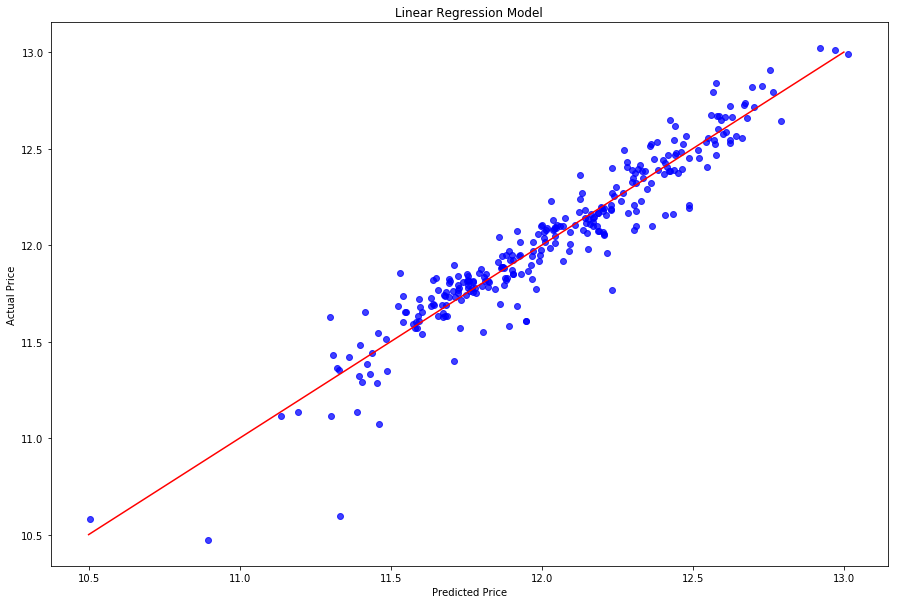

In [205]:

actual_values = y_test
plt.figure(figsize=(15,10))
plt.scatter(predictions, actual_values, alpha=.75,
            color='b') 
plt.plot([10.5,13],[10.5,13],"r")
plt.xlabel('Predicted Price')
plt.ylabel('Actual Price')
plt.title('Linear Regression Model')
plt.show()

### Ridge Regularization

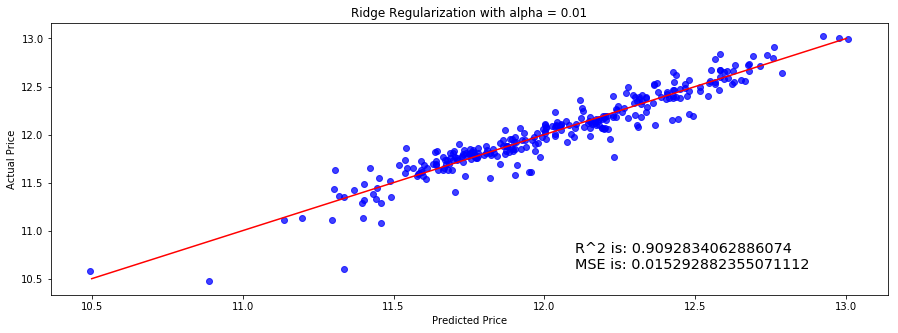

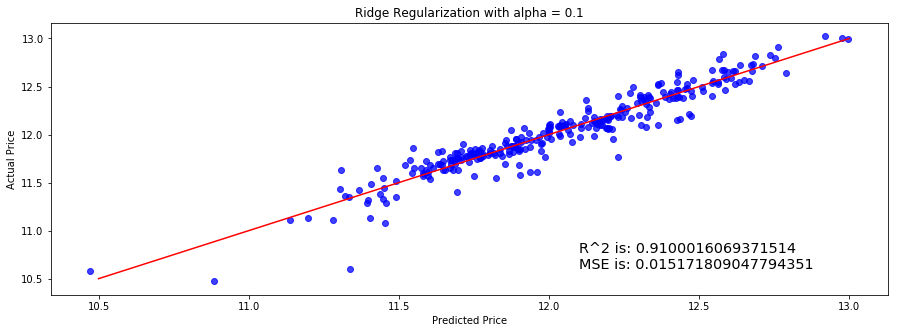

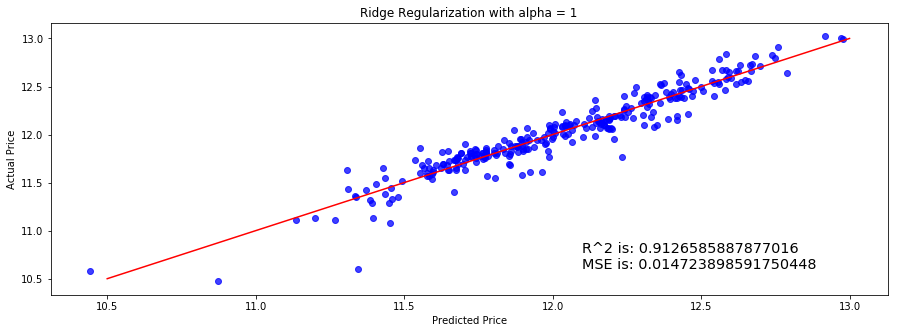

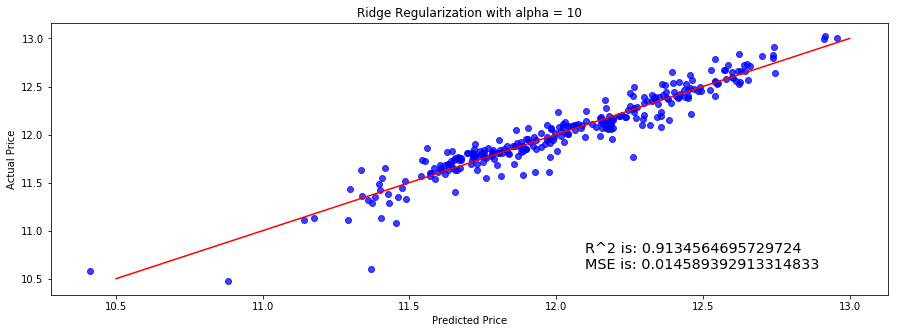

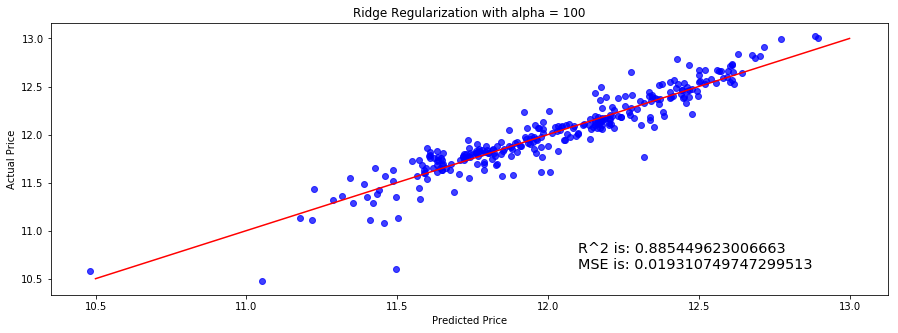

In [206]:
for alpha in [0.01,0.1,1,10,100]:
    rm = Ridge(alpha=alpha)
    ridge_model = rm.fit(X_train, y_train)
    preds_ridge = ridge_model.predict(X_test)
    plt.figure(figsize=(15,5))
    plt.scatter(preds_ridge, actual_values, alpha=.75, color='b')
    plt.plot([10.5,13],[10.5,13],"r")
    plt.xlabel('Predicted Price')
    plt.ylabel('Actual Price')
    plt.title('Ridge Regularization with alpha = {}'.format(alpha))
    overlay = 'R^2 is: {}\nMSE is: {}'.format(
                    ridge_model.score(X_test, y_test),
                    mean_squared_error(y_test, preds_ridge))
    plt.annotate(s=overlay,xy=(12.1,10.6),size='x-large')
    plt.show()

### Lasso regression

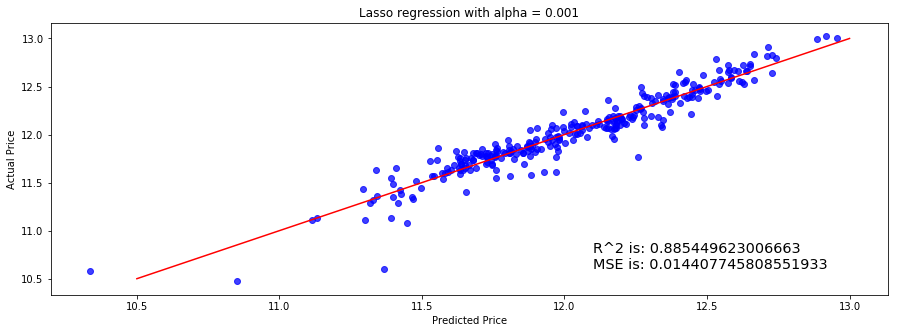

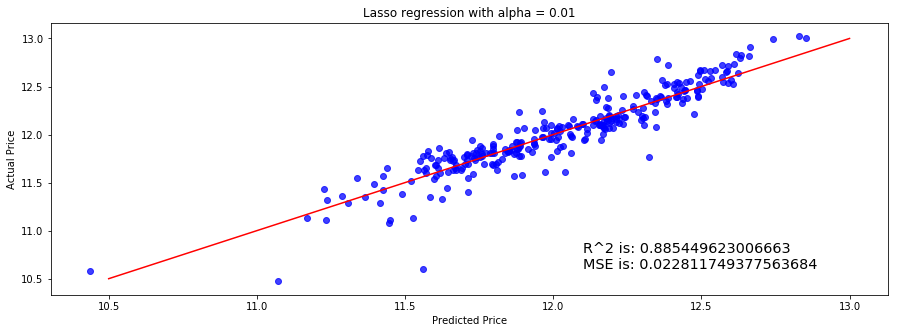

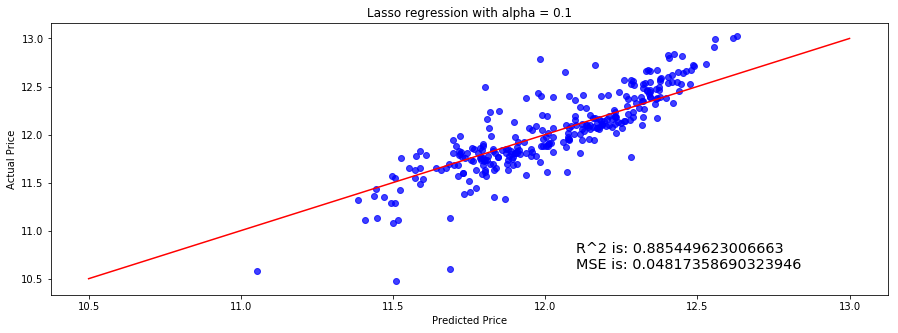

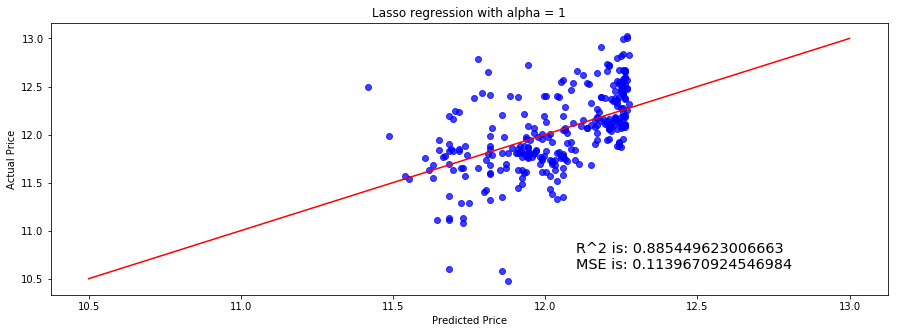

In [207]:
for alpha in [0.001,0.01,0.1,1]:
    lm = Lasso(alpha=alpha)
    lasso_model = lm.fit(X_train, y_train)
    preds_ridge = lasso_model.predict(X_test)
    plt.figure(figsize=(15,5))
    plt.scatter(preds_ridge, actual_values, alpha=.75, color='b')
    plt.plot([10.5,13],[10.5,13],"r")
    plt.xlabel('Predicted Price')
    plt.ylabel('Actual Price')
    plt.title('Lasso regression with alpha = {}'.format(alpha))
    overlay = 'R^2 is: {}\nMSE is: {}'.format(
                    ridge_model.score(X_test, y_test),
                    mean_squared_error(y_test, preds_ridge))
    plt.annotate(s=overlay,xy=(12.1,10.6),size='x-large')
    plt.show()

## Random Forrest

In [208]:
fr = RandomForestRegressor(n_estimators=100,random_state=42)
randomForrestModel = fr.fit(X_train, y_train)
print ("R^2 is:", randomForrestModel.score(X_test, y_test))

R^2 is: 0.8699054344741685


In [209]:
predictions = randomForrestModel.predict(X_test)
print ('MSE is:', mean_squared_error(y_test, predictions))

MSE is: 0.021931168314698078


In [210]:
scores = cross_val_score(randomForrestModel, X_test, y_test, cv=10)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

Accuracy: 0.83 (+/- 0.15)


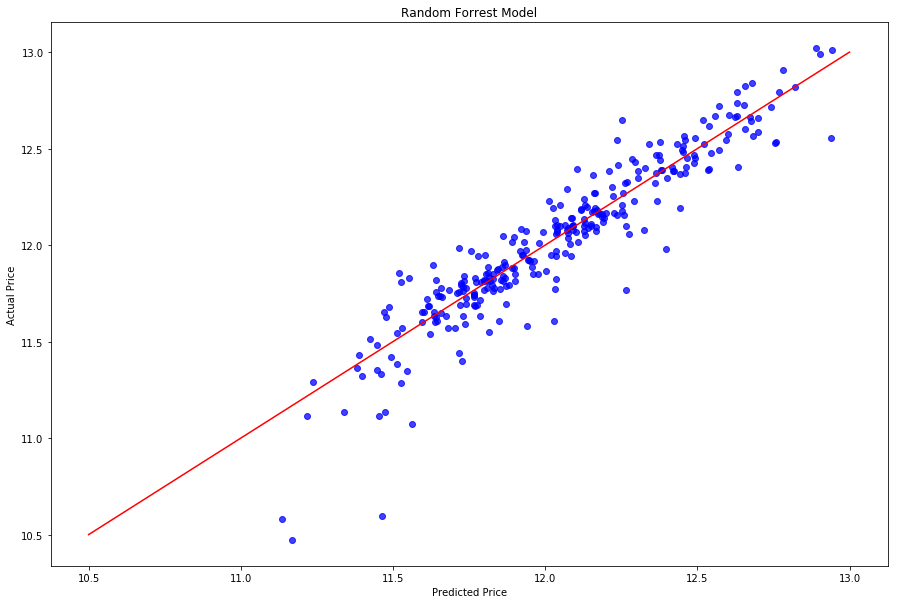

In [211]:
actual_values = y_test
plt.figure(figsize=(15,10))
plt.scatter(predictions, actual_values, alpha=.75,
            color='b') 
plt.plot([10.5,13],[10.5,13],"r")
plt.xlabel('Predicted Price')
plt.ylabel('Actual Price')
plt.title('Random Forrest Model')
plt.show()

## Gradient boosting

In [212]:
gb = ensemble.GradientBoostingRegressor()
gradientBoostingModel = gb.fit(X_train, y_train)
print ("R^2 is:", gradientBoostingModel.score(X_test, y_test))

R^2 is: 0.900810933197954


In [213]:
predictions = gradientBoostingModel.predict(X_test)
print ('MSE is:', mean_squared_error(y_test, predictions))

MSE is: 0.01672116056670764


In [214]:
scores = cross_val_score(gradientBoostingModel, X_test, y_test, cv=10)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

Accuracy: 0.86 (+/- 0.12)


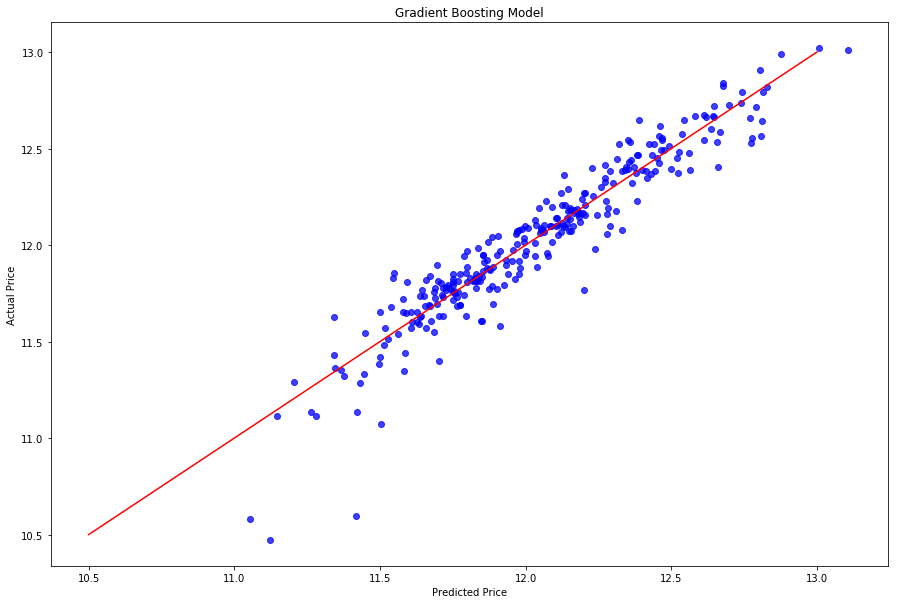

In [215]:
actual_values = y_test
plt.figure(figsize=(15,10))
plt.scatter(predictions, actual_values, alpha=.75,
            color='b') 
plt.plot([10.5,13],[10.5,13],"r")
plt.xlabel('Predicted Price')
plt.ylabel('Actual Price')
plt.title('Gradient Boosting Model')
plt.show()

In [216]:
importances = gb.feature_importances_
columns = X.columns
featureImportances = sorted(list(zip(columns,importances)),key=lambda x: x[1],reverse=True)
print(np.array(featureImportances))

[['LotArea' '0.07934555870256338']
 ['TotalSF' '0.07889091702818102']
 ['GrLivArea' '0.05772658712611385']
 ['BsmtUnfSF' '0.05580043276098458']
 ['GarageYrBlt' '0.05315801919319381']
 ['OverallQual' '0.0499124556066096']
 ['AvgQual' '0.04028709568488073']
 ['GarageArea' '0.039139176224116126']
 ['Age' '0.03688931301916802']
 ['TotalPorchSF' '0.03193649538325325']
 ['YearBuilt' '0.03096917971998087']
 ['OverallCond' '0.02982249669825297']
 ['BsmtFinSF1' '0.02785083273008385']
 ['N5' '0.02136541533706058']
 ['1stFlrSF' '0.02038815560107115']
 ['OpenPorchSF' '0.020116047936803126']
 ['Fireplaces' '0.01917397774832715']
 ['YearRemodAdd' '0.01888305227531729']
 ['MoSold' '0.018756086506586868']
 ['WoodDeckSF' '0.018411443085701175']
 ['EncodedSound' '0.0147315255860476']
 ['N21' '0.01447039380064781']
 ['YrSold' '0.013355506898876768']
 ['EncodedStreet' '0.012010522216504718']
 ['GarageCars' '0.011620447387763745']
 ['TotalBsmtSF' '0.011595429853393338']
 ['EncodedMSZoning' '0.0112085997924

### Improving Gradient Boosting

In [217]:
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None, n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5)):
    plt.figure(figsize=(15,5))
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve( estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.1, color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")
    plt.legend(loc="best")
    return plt

In [218]:
def GradientBooster(param_grid, n_jobs): 
    estimator = GradientBoostingRegressor()
    cv = ShuffleSplit(X_train.shape[0], n_iter=10, test_size=0.2)
    classifier = GridSearchCV(estimator=estimator, cv=cv, param_grid=param_grid, n_jobs=n_jobs)
    classifier.fit(X_train, y_train)
    print("Best Estimator learned through GridSearch")
    print(classifier.best_estimator_)
    return cv, classifier.best_estimator_

In [219]:
param_grid={'n_estimators':[100],
            'learning_rate': [0.1],
            'max_depth':[6],
            'min_samples_leaf':[3],
            'max_features':[1.0],
           }
n_jobs=4
cv,best_est=GradientBooster(param_grid, n_jobs)

Best Estimator learned through GridSearch
GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=6, max_features=1.0,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=3,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=100, presort='auto', random_state=None,
             subsample=1.0, verbose=0, warm_start=False)


<module 'matplotlib.pyplot' from '/home/marius/.local/lib/python3.6/site-packages/matplotlib/pyplot.py'>

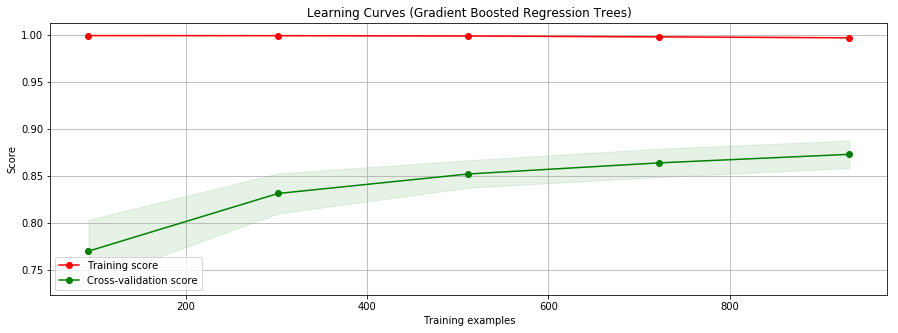

In [220]:
estimator = GradientBoostingRegressor(n_estimators=best_est.n_estimators, max_depth=best_est.max_depth,
            learning_rate=best_est.learning_rate, min_samples_leaf=best_est.min_samples_leaf,
            max_features=best_est.max_features)
title = "Learning Curves (Gradient Boosted Regression Trees)"
plot_learning_curve(estimator, title, X_train, y_train, cv=cv, n_jobs=n_jobs)

In [221]:
estimator.fit(X_train, y_train)
predictions = estimator.predict(X_test)
print ('MSE is:', mean_squared_error(y_test, predictions))

MSE is: 0.021168522529496272


In [222]:
param_grid={'n_estimators':[100,500,1000,2000],
            'learning_rate': [0.1, 0.05, 0.02, 0.01],
            'max_depth':[4,6],
            'min_samples_leaf':[3,5,9,17], 
            'max_features':[1.0,0.3,0.1]
           }
n_jobs=4
#cv,best_est=GradientBooster(param_grid, n_jobs)
"""
try:
    best_est = pickle.load( open( "GradientBoostingBestEstimator.p", "rb" ) )
    cv = pickle.load( open( "GradientBoostingCV.p", "rb" ) )
except:
    cv,best_est=GradientBooster(param_grid, n_jobs)
"""
cv = ShuffleSplit(X_train.shape[0], n_iter=10, test_size=0.2)

In [223]:
#pickle.dump(best_est, open( "GradientBoostingBestEstimator.p", "wb" ) )
#pickle.dump(cv, open( "GradientBoostingCV.p", "wb" ) )

<module 'matplotlib.pyplot' from '/home/marius/.local/lib/python3.6/site-packages/matplotlib/pyplot.py'>

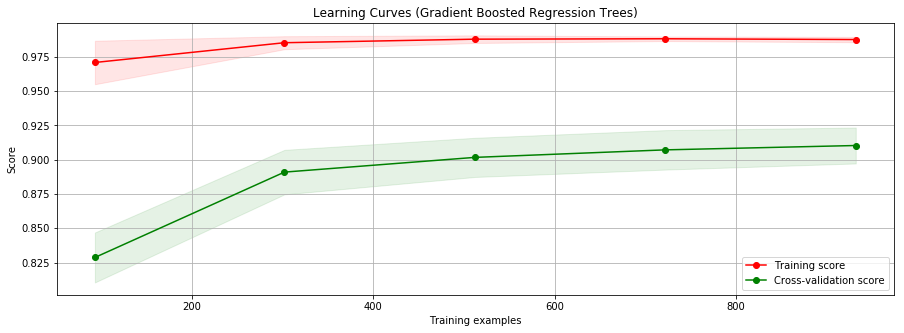

In [224]:
"""
estimator = GradientBoostingRegressor(n_estimators=best_est.n_estimators, max_depth=best_est.max_depth,
            learning_rate=best_est.learning_rate, min_samples_leaf=best_est.min_samples_leaf,
            max_features=best_est.max_features)
"""
estimator = GradientBoostingRegressor(n_estimators=3000, learning_rate=0.05,
                                   max_depth=4, max_features='sqrt',
                                   min_samples_leaf=15, min_samples_split=10, 
                                   loss='huber', random_state =5)

title = "Learning Curves (Gradient Boosted Regression Trees)"
plot_learning_curve(estimator, title, X_train, y_train, cv=cv, n_jobs=n_jobs)


In [225]:
estimator.fit(X_train, y_train)
predictions = estimator.predict(X_test)
print ("R^2 is:", estimator.score(X_test, y_test))
print ('MSE is:', mean_squared_error(y_test, predictions))

R^2 is: 0.9061531495125592
MSE is: 0.015820576866723137


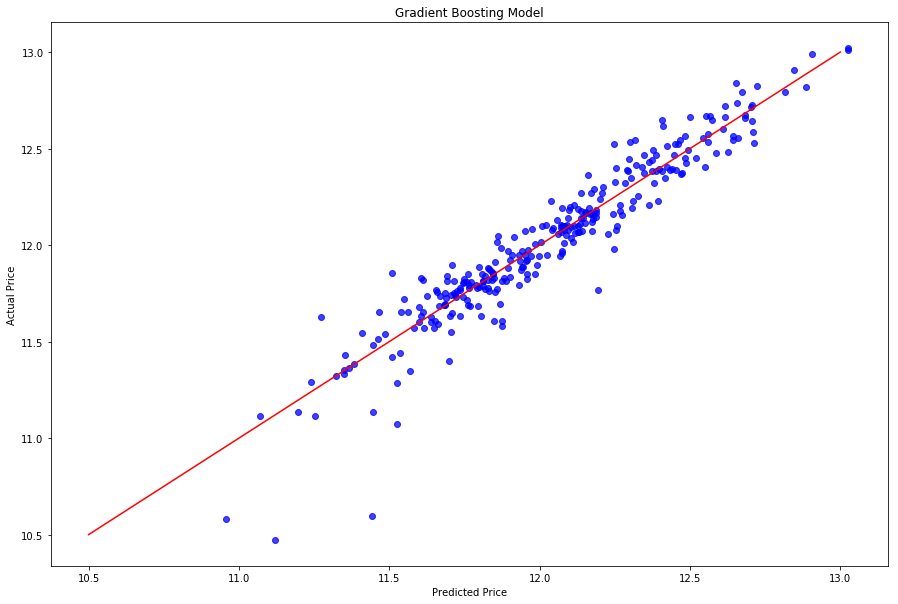

In [226]:
actual_values = y_test
plt.figure(figsize=(15,10))
plt.scatter(predictions, actual_values, alpha=.75,
            color='b') 
plt.plot([10.5,13],[10.5,13],"r")

plt.xlabel('Predicted Price')
plt.ylabel('Actual Price')
plt.title('Gradient Boosting Model')
plt.show()

### Using XGBoost 

<module 'matplotlib.pyplot' from '/home/marius/.local/lib/python3.6/site-packages/matplotlib/pyplot.py'>

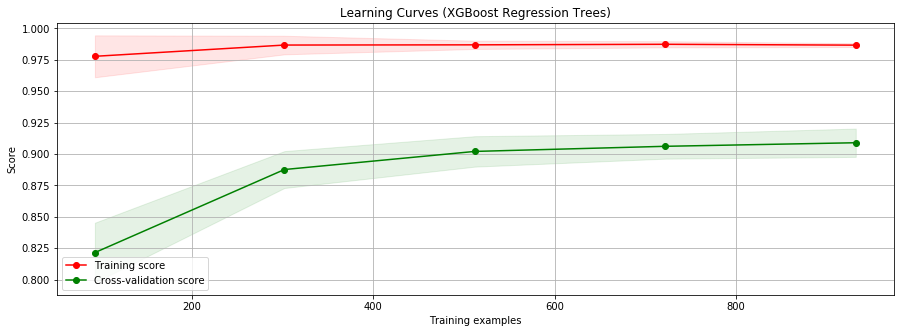

In [227]:
model_xgb = xgb.XGBRegressor(colsample_bytree=0.4603, gamma=0.0468, 
                             learning_rate=0.05, max_depth=3, 
                             min_child_weight=1.7817, n_estimators=2200,
                             reg_alpha=0.4640, reg_lambda=0.8571,
                             subsample=0.5213, silent=1,
                             random_state =7, nthread = -1)
title = "Learning Curves (XGBoost Regression Trees)"
plot_learning_curve(estimator, title, X_train, y_train, cv=cv, n_jobs=n_jobs)

In [228]:
model_xgb.fit(X_train, y_train)
xgb_preds = model_xgb.predict(X_test)

print ("R^2 is:", model_xgb.score(X_test, y_test))
print ('MSE is:', mean_squared_error(y_test, xgb_preds))

R^2 is: 0.9022436016955602
MSE is: 0.016479643222511397


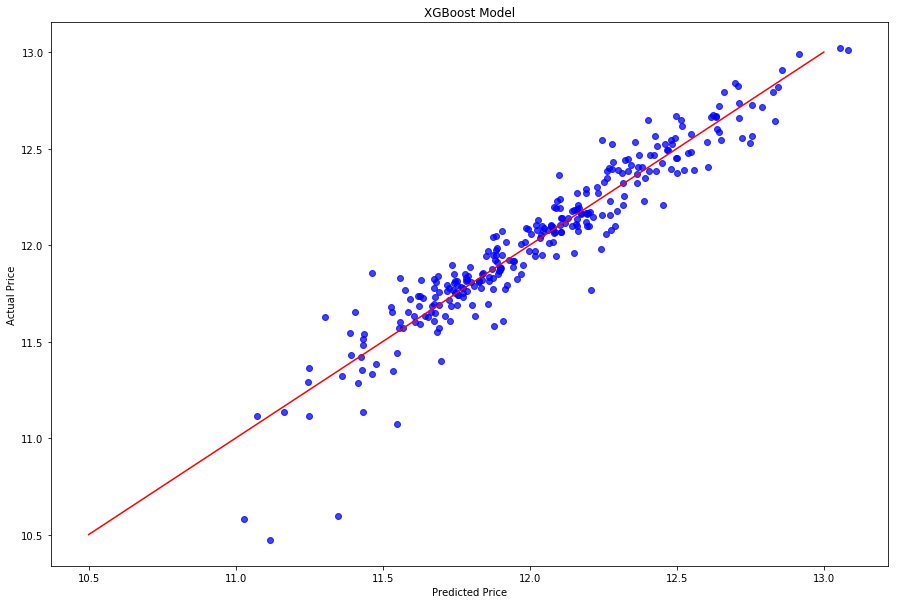

In [229]:
actual_values = y_test
plt.figure(figsize=(15,10))
plt.scatter(xgb_preds, actual_values, alpha=.75,
            color='b') 
plt.plot([10.5,13],[10.5,13],"r")

plt.xlabel('Predicted Price')
plt.ylabel('Actual Price')
plt.title('XGBoost Model')
plt.show()

### Using LightGBM

In [ ]:
model_lgb = lgb.LGBMRegressor(objective='regression',num_leaves=5,
                              learning_rate=0.05, n_estimators=720,
                              max_bin = 55, bagging_fraction = 0.8,
                              bagging_freq = 5, feature_fraction = 0.2319,
                              feature_fraction_seed=9, bagging_seed=9,
                              min_data_in_leaf =6, min_sum_hessian_in_leaf = 11)
title = "Learning Curves (LightGBM Regression Trees)"
plot_learning_curve(estimator, title, X_train, y_train, cv=cv, n_jobs=n_jobs)

In [ ]:
model_lgb.fit(X_train, y_train)
lgb_preds = model_lgb.predict(X_test)

print ("R^2 is:", model_lgb.score(X_test, y_test))
print ('MSE is:', mean_squared_error(y_test, lgb_preds))

In [ ]:
actual_values = y_test
plt.figure(figsize=(15,10))
plt.scatter(lgb_preds, actual_values, alpha=.75,
            color='b') 
plt.plot([10.5,13],[10.5,13],"r")

plt.xlabel('Predicted Price')
plt.ylabel('Actual Price')
plt.title('LightLGB Model')
plt.show()

# Create submission

In [ ]:
testDF = makeFeatures(testDF)
testDF = fixSkew(testDF)

testData = testDF[training_features].select_dtypes(include=[np.number]).interpolate().dropna()

In [ ]:
gb_preds = estimator.predict(testData)
xgb_preds = model_xgb.predict(testData)
#lr_predictions = linearModel.predict(testData)
lm = Lasso(alpha=0.001)
lasso_model = lm.fit(X_train, y_train)
ls_preds = lasso_model.predict(testData)
lgb_preds = model_lgb.predict(testData)

final_predictions = (0.3 * np.exp(gb_preds) + 0.3 *  np.exp(ls_preds) + 0.1 * np.exp(xgb_preds) + 0.3 * np.exp(lgb_preds))

submission = pd.DataFrame()
submission['Id'] = idColl
submission['SalePrice'] = final_predictions
submission.head(20)


In [ ]:

ansDF = pd.read_csv(base + "train2.csv")
idColl = ansDF.Id
ansDF = ansDF.drop(["Id"],axis=1)
ansDF.index = idColl
ansDF = pd.DataFrame(ansDF.SalePrice[1200:])
ansDF["Predicted"] = submission.SalePrice.values
ansDF.head(20)

#diff = np.sum(np.log(np.square((np.array(ansDF.values) - np.array(submission.SalePrice.values)))))


In [ ]:
submission.to_csv('submission1.csv', index=False)